# Lab - Data-Centric Evaluation of ML Models

This lab is intended to accompany the lecture on Data-Centric Evaluation of ML Models. In this lab, you are given a training dataset and your goal is to improve the dataset in order to boost the accuracy of a fixed classification model on a given (fixed) test dataset. Reviewing the lecture notes will be helpful to get some ideas.

You can get all the dependencies you need for this notebook by running:

In [1]:
# !pip install cleanlab matplotlib

In [2]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score

import matplotlib.pyplot as plt

In [3]:
SEED = 123
np.random.seed(SEED)  # for reproducibility

# Load dataset

The data come from a 3-class classification task where the goal is to predict `y` based on features `x1`, ..., `x5`.
We convert the data to a numpy array format.

In [4]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [5]:
df.head()

,x0,x1,x2,x3,x4,x5,y
0,-0.333489,-0.770208,-2.697486,-0.628563,-1.277720,100.0,2
1,-0.787124,1.230800,1.415472,-0.805927,0.175115,100.0,1
2,0.781197,-0.856227,2.138879,2.495417,0.868192,100.0,1
3,1.895093,-0.885939,1.946352,-2.082747,0.064914,100.0,1
4,0.689091,-5.091299,-2.218682,0.330767,3.012755,100.0,2


In [6]:
df_test.head()

,x0,x1,x2,x3,x4,x5,y
0,2.337701,-0.681121,1.883774,0.949812,-0.311507,-100.0,1
1,1.101249,-2.032961,0.344490,0.724925,1.355534,-100.0,2
2,1.791349,-2.808856,-1.409471,0.552069,0.433901,100.0,2
3,2.082599,0.811498,0.906920,-0.749352,1.974424,-100.0,2
4,1.214627,-0.448392,1.812024,0.429543,0.396450,-100.0,1


In [7]:
temp = df.copy()
y = temp["y"].values
temp.drop(columns=["y"], inplace=True)
X = temp.values

y_test = df_test["y"].values
df_test.drop(columns=["y"], inplace=True)
X_test = df_test.values

print(X)
print(y)

[[  -0.33348927   -0.7702077    -2.69748604   -0.62856274   -1.27772042
   100.        ]
 [  -0.7871239     1.23080016    1.41547226   -0.8059272     0.1751147
   100.        ]
 [   0.78119711   -0.85622725    2.13887864    2.49541712    0.86819164
   100.        ]
 ...
 [   1.19101444   -1.72465036   -1.17854745   -1.54881816   -1.51740071
  -100.        ]
 [  -2.03358571   -0.23977122    1.21509471    0.86023614    0.69816843
   100.        ]
 [   0.15125519   -1.21711969    2.77498591    0.7090941     0.89159205
  -100.        ]]
[2 1 1 ... 2 1 1]


Here's a simple plot of the first two features, colored by class. Visualizing the dataset may be helpful to you in this assignment, but can be tricky with 6-dimensional features!

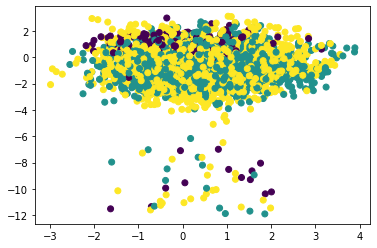

In [8]:
plt.scatter(X[:,0], X[:,1], c=list(y))

# Improve ML Model via data-centric techniques

We train a simple neural network model (Multi-Layer Perceptron classifier) and evaluate it on the given test set. 
Note that the evaluation metric used is `balanced_accuracy`. This is the accuracy amongst all examples in a given class, averaged over all classes, which better represents performance on minority classes.

You should never change the test data labels `y_test` in this lab, nor the neural network model. You may change the training data `X`, `y` as you see fit, and update `X_test` accordingly so your model is able to make predictions on it.

In [9]:
def train_evaluate_model(X, y, X_test, y_test):
    model = MLPClassifier(early_stopping=True, random_state=SEED)
    model.fit(X, y)
    predictions = model.predict(X_test)
    acc = balanced_accuracy_score(y_true=y_test, y_pred=predictions)
    print(f"Balanced accuracy = {acc}")
    return predictions

A baseline version of the model is trained on the original given data:

In [10]:
predictions = train_evaluate_model(X, y, X_test, y_test)

Balanced accuracy = 0.5759397707696671


# Exercise

Your goal is to produce a version of this same model that has much better test accuracy! 
You should accomplish this by changing `X` and `y` as you see fit. Consider various ideas presented in the lecture and look through the data yourself to see if other ideas come to mind! Greater than 80% test accuracy is achievable without modifying the model at all. If you choose to drop/add features to `X` or renormalize some values, then you'll want to apply these operations to `X_test` as well.

In [11]:
## TODO: find my_X, my_y such that train_evaluate_model(my_X, my_y, X_test, y_test)
## reports better (higher) performance.

Confusion Matrix를 통해 어떤 오류가 많이 발생했는지 확인해본다.

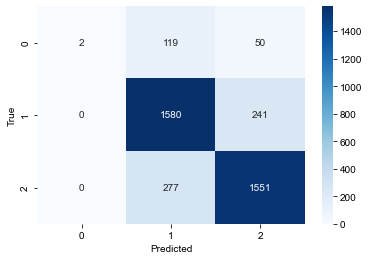

In [12]:
from sklearn import metrics
import seaborn as sns

confusion_matrix = metrics.confusion_matrix(y_test, predictions)
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
sns.set(rc={'figure.figsize':(10, 7)})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

모델이 label 0에 대한 예측을 거의 하지 못하고 있다. EDA를 좀 더 수행해본다.

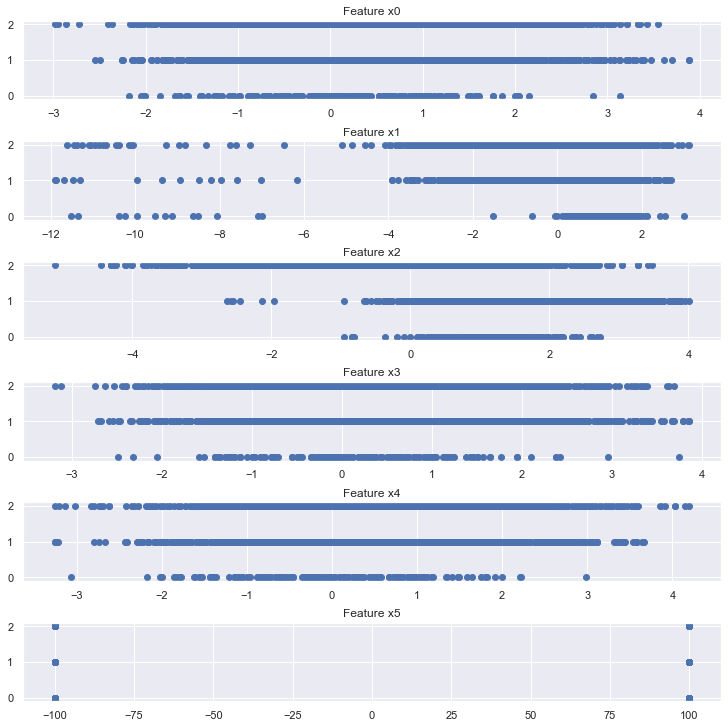

In [13]:
fig, ax = plt.subplots(X.shape[1], constrained_layout=True)
fig.set_figwidth(10)
fig.set_figheight(10)

for i in range(X.shape[1]):
    ax[i].scatter(X[:, i], y)
    ax[i].set_title(f'Feature x{i}')

성능 개선을 위해 2가지 작업을 한다.
1. 이상치가 많이 존재하는 'x1' feature의 이상치를 제거한다.
2. over sampling을 수행한다.

In [14]:
from collections import defaultdict


# 이상치 상한, 하한 얻기
def get_limits(df, columns):
    limits = defaultdict(list)

    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper_limit = q3 + 1.5 * iqr
        lower_limit = q1 - 1.5 * iqr

        limits[col].extend([upper_limit, lower_limit])

    return limits


# 이상치 제거
def delete_outliers(df, columns, limits):
    df = df.copy()
    deleted_indices = set()

    for col in columns:
        upper_limit, lower_limit = limits[col]
        indices = df.loc[(df[col] > upper_limit) | (df[col] < lower_limit)].index
        deleted_indices.update(list(indices))
    
    df_deleted = df.drop(deleted_indices)
    df_deleted.reset_index(drop=True, inplace=True)
    
    return df_deleted, deleted_indices

In [15]:
# 이상치 처리의 기준이 되는 상한, 하한 값 구하기
limits = get_limits(df, ['x1'])

# 이상치 제거
df_deleted, _ = delete_outliers(df, ['x1'], limits)

In [16]:
# 이상치 제거한 데이터셋으로 my_X, my_y 만들기
temp = df_deleted.copy()
my_y = temp.pop('y')
my_X = temp.values

In [17]:
predictions = train_evaluate_model(my_X, my_y, X_test, y_test)

Balanced accuracy = 0.6442081281684828


이상치 제거로 성능이 약간 개선되었다. 이제 over sampling을 수행한다.

In [18]:
from imblearn.over_sampling import SMOTE

my_X, my_y = SMOTE(random_state = SEED).fit_resample(my_X, my_y)

In [19]:
predictions = train_evaluate_model(my_X, my_y, X_test, y_test)

Balanced accuracy = 0.8028728658609405


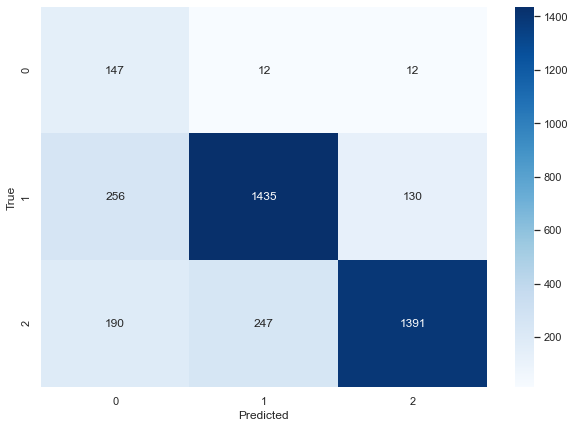

In [20]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
sns.set(rc={'figure.figsize':(10, 7)})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()